In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from adafnn import MyAdaFNN
from train import train_pipeline, test_pipeline

# Introduction

&emsp; In the field of functional data analysis, basis expansion methods have been traditionally used to model intrinsically infinite-dimensional functions in finite-dimensional space. Among basis expansion methods, two of the most popular are B-spline and Functional Principal Component Analysis (FPCA). B-spline uses a set of $M$ pre-determined basis functions $\{B_1(t), \cdots, B_M(t) \}$ to model a given functional data $X_n$ as $X_n(t) \approx \sum_{m=1}^M c_{nm} B_m(t)$, where $c_{nm}$ is the coefficient for the $n\text{-th}$ data and $m\text{-th}$ basis. In FPCA, a set of $M$ orthonormal eigenvectors $\{v_1(t), \cdots, v_M(t) \}$ is used as basis functions, so that the functional data $X_n$ is modeled as $X_n(t) \approx \sum_{m=1}^M \xi_{nm} v_m(t)$ where $\xi_{nm} = \langle X_n, v_m \rangle$ is the $m \text{-th}$ PC score for $X_n$ (assuming that $X_n$ is centered).

&emsp; Current basis expansion methods have proven to work quite well for functional data analysis, but they do pose some drawbacks. First and foremost, selection of basis functions must be preceded before fitting the data (for B-spline). This means that we cannot choose basis functions that are optimal for each dataset. Also, current methods don't take advange of information in the output and only try to capture the information in input (for FPCA). To address these problems, Yao et al.[1] introduced a method of adaptively learning basis functions using neural networks.

# AdaFNN

&emsp; AdaFNN is a model introduced by Yao et al.[1] in 2021, where we use micro neural networks to adaptively learn basis functions using information from the target via backpropagation. The key idea is that adaptive basis layers can learn to focus on information relevant to the
target, thus enabling the construction of optimal basis functions

## Architecture

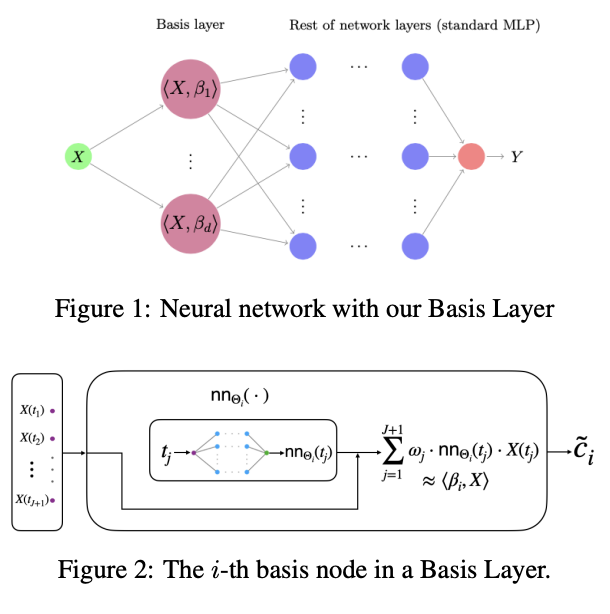

&emsp; The above image from [1] is an illustration of the network. The Basis Layer consists of $d$ Basis Nodes, where each Basis Node is a micro neural networks that takes time points as input. For each Basis Node, the time points are pases through consecutive feed-forward netwoks, and outputs the basis value correspoding to each time point. Thus, each Basis Node produces one basis function. After constructing $d$ basis functions, we compute the inner product between the input and each basis function via numerical integration, which results in a vector of size $d$. This vector is passed on to the subsequent network to be used for the downstream task. This network can be trained end-to-end and all layers are differentiable, which means information regarding the target can be reflected in constructing basis finctions via backpropagation. Additionally, some regularizations are applied to the loss function to encourage basis orthogonality and basis sparsity, and we refer interested readers to [1] for more detail.

# Network for recovering underlying curve from contaminated discrete observations

&emsp; We utilize the basic idea of adapative basis layers used in AdaFNN, but make some change in architecture. Before going in, it will be critical to point out that our task is different from that of the original paper. The original paper aimed to predict a scalar output from a functional input (scalar-on-function scheme), while we aim to reconstruct the underlying function from discrete observations contaminated by noise (function-on-function scheme).

## Architecture Change

&emsp; We still utilize the micro network structure to compute basis functions and scores ($\tilde{c}_i = \langle \tilde{\beta}_i, X \rangle$), where $\tilde{\beta}_i, \tilde{c}_i$ are the estimated basis and corresponding score. However, there are two important changes:
- A linear transformation is applied to the basis computed by the micro network
- Instead of using the scores as input to the next FC layer, we compute the output by $\sum_i \tilde{c}_i \tilde{\beta}_i$

### Linear Transformation of Basis

The first idea is inspired by the fact that any basis can be made orthonormal via some linear (matrix) transformation $\textbf{W}$, that is
    $$
    B'_m(t) = \sum_{m_1}W_{mm_1}B_{m_1}(t)
    $$
$B'_m(t)$ are an orthonormal basis. We let the neural network find the unknown transformation $\textbf{W}$ via backpropagation

### Parceval's Theorem

The second idea is inspired by Parceval's Theorem. Parceval's Theorem states as the following: Letting $\{e_i\}$ be an orthonormal basis of a real separable Hilbert space $\mathcal{H}$, then for any $x \in \mathcal{H}$ we have
    $$
    x = \sum_{i=1}^\infty \langle x, e_i \rangle e_i
    $$
By constructing the output of the network to have the form $\sum_i \tilde{c}_i \tilde{\beta}_i$ where $\tilde{c}_i = \langle \tilde{\beta}_i, X \rangle$, we hope that the basis will learn to have an orthonormal structure even without an extra regularization term (like the one used in the original paper).

# Data Generation

10000 functional data with 101 equally spaced time points between 0 and 1 are generated, where $60\%$ of the data is used for training, $20\%$ for validation and $20\%$ for testing. Data was generated with the following scheme:


- Construct 10 base functions: $\cos(k \pi t)$ for $k=1, \cdots , 10$
- For each data, randomly sample 3 base functions (without replacement).
- Sum the sampled base functions
- For each time point, sample Gaussian noise from $N(0, \sigma^2)$ ($\sigma = \frac{1}{2}$ used for this experiment)
- Add the Gaussian noise to the data

Denoting the underlying curve as $X(t)$, each observed data can be expressed as
$$
Y(t) = X(t) + \epsilon(t)
$$

In [45]:
! python generate_data.py

In [143]:
noise_train = torch.load("data/mydata/train/noise_train.pt").numpy()
original_train = torch.load("data/mydata/train/original_train.pt").numpy()

noise_val = torch.load("data/mydata/val/noise_val.pt").numpy()
original_val = torch.load("data/mydata/val/original_val.pt").numpy()

noise_test = torch.load("data/mydata/test/noise_test.pt").numpy()
original_test = torch.load("data/mydata/test/original_test.pt").numpy()

# matern = torch.load("data/matern/data.pt").numpy()

# adafnn_data = torch.load("data/adafnn/original_data.pt").numpy()
# adafnn_data_noise = torch.load("data/adafnn/noise_data.pt").numpy()

Let's visualize the first three training data.

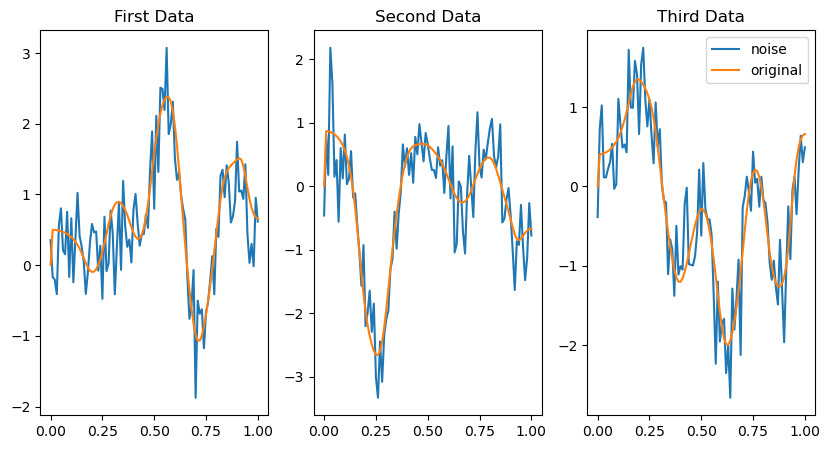

In [144]:
# visualize the first data
tseq = torch.linspace(0,1,101)

fig, ax = plt.subplots(1,3, figsize=(10,5))
ax[0].plot(tseq, noise_train[0], label="noise")
ax[0].plot(tseq, original_train[0], label="original")
ax[0].set_title("First Data")
ax[1].plot(tseq, noise_train[1], label="noise")
ax[1].plot(tseq, original_train[1], label="original")
ax[1].set_title("Second Data")
ax[2].plot(tseq, noise_train[2], label="noise")
ax[2].plot(tseq, original_train[2], label="original")
ax[2].set_title("Third Data")
plt.legend()
plt.show();

# Experiment

## Train

The train setting is as follows:
- Trained for 200 epochs
- Batch size 128
- Learning rate 5e-4
- Learning rate scheduler for every 30 epochs by 0.5
- 7 Basis Nodes where each Basis Node has 5 hiddens layers of size 256 and dropout 0.1
- No regularization
- MSE is used as the loss function:
    $$
    \frac{\sum_n \sum_t (Y_n(t) - \hat{Y}_n(t))^2}{NT}
    $$
    where $\hat{Y}_n = \sum_i \tilde{c}_{in} \tilde{\beta}_i$ and $\tilde{c}_{in} = \langle \tilde{\beta}_i, X_n \rangle$

In [106]:
config = dict(
    epochs = 200,
    batch_size = 128,
    lr = 5e-4,
    device = "cuda" if torch.cuda.is_available() else "cpu",
    gamma = 0.5,
    step_size = 30,
    x_train_path="data/mydata/train/noise_train.pt",
    y_train_path="data/mydata/train/noise_train.pt",
    x_val_path="data/mydata/val/noise_val.pt",
    y_val_path="data/mydata/val/noise_val.pt",
    x_test_path="data/mydata/test/noise_test.pt",
    y_test_path="data/mydata/test/original_test.pt",
    model_params = dict(
        n_base = 7,
        base_hidden = [256, 256, 256, 256, 256],
        # base_hidden = [128, 128, 128, 128],
        tseq = torch.linspace(0, 1, 101),
        dropout = 0.1,
        lambda1 = 0,
        lambda2 = 0,
        device = "cuda" if torch.cuda.is_available() else "cpu"
    )
)

In [ ]:
torch.manual_seed(123)

model = MyAdaFNN(**config["model_params"]).to(config["device"])
train_pipeline(model, config)

The basis trained by the model look as follows.

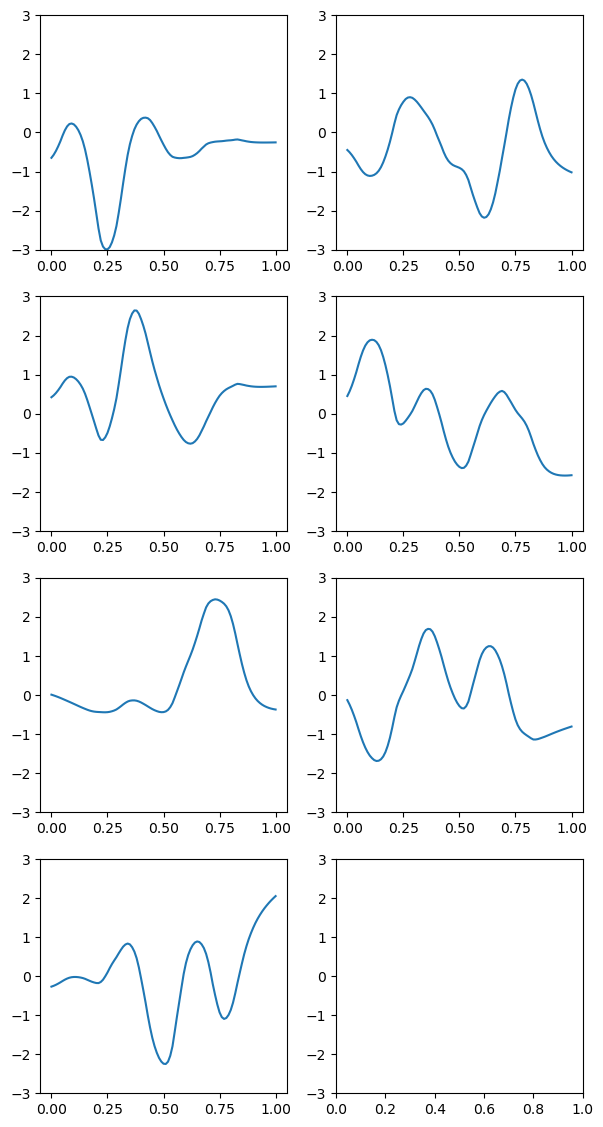

In [145]:
model.plot_bases()

By checking orthogonality between basis trained by the network, we can indeed find that the basis are mostly orthogonal even without any regularizations regarding orthogonality

In [146]:
model.check_orthonormality()

Inner Product between basis 1 and basis 2: -0.03024805523455143
Inner Product between basis 1 and basis 3: 0.0537111759185791
Inner Product between basis 1 and basis 4: 0.04355162754654884
Inner Product between basis 1 and basis 5: 0.011082896962761879
Inner Product between basis 1 and basis 6: -0.0019544183742254972
Inner Product between basis 1 and basis 7: -0.07338955253362656
Inner Product between basis 2 and basis 3: 0.05474207550287247
Inner Product between basis 2 and basis 4: 0.030396610498428345
Inner Product between basis 2 and basis 5: 0.07599390298128128
Inner Product between basis 2 and basis 6: 0.01632017269730568
Inner Product between basis 2 and basis 7: -0.05514183267951012
Inner Product between basis 3 and basis 4: 0.03348832204937935
Inner Product between basis 3 and basis 5: -0.036892279982566833
Inner Product between basis 3 and basis 6: 0.0256648026406765
Inner Product between basis 3 and basis 7: 0.03415996953845024
Inner Product between basis 4 and basis 5: 0.04

## Test

We use the same MSE loss function for testing just as we did in training. However, unlike the training stage, we derive the loss by comparing our network output against the true underlying curve instead of the noisy observations to see how well our model predicted the true curve.

In [147]:
with torch.no_grad():
    pred = model(torch.from_numpy(noise_test))

Let's see our model's test error

In [148]:
print("Test Loss:", torch.mean((pred - torch.from_numpy(original_test))**2).item())

Test Loss: 0.24057534337043762


Let's visualize the output results of the first three test data.

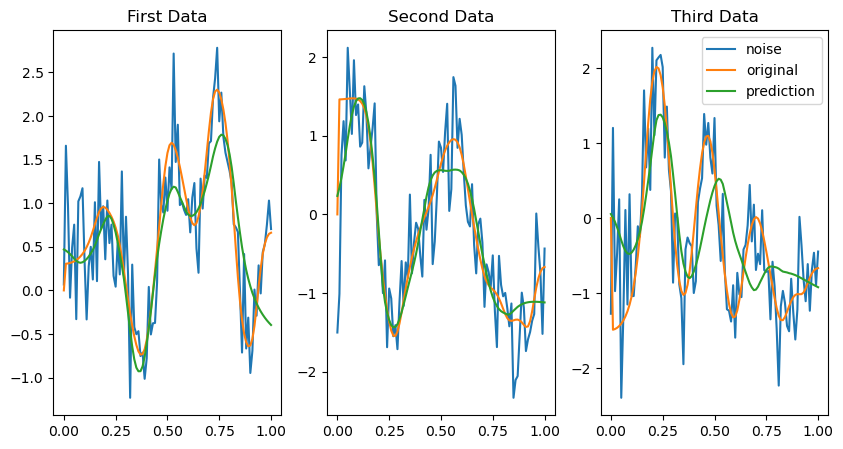

In [149]:
fig, ax = plt.subplots(1,3, figsize=(10,5))
ax[0].plot(tseq, noise_test[0], label="noise")
ax[0].plot(tseq, original_test[0], label="original")
ax[0].plot(tseq, pred[0].detach(), label="prediction")
ax[0].set_title("First Data")
ax[1].plot(tseq, noise_test[1], label="noise")
ax[1].plot(tseq, original_test[1], label="original")
ax[1].plot(tseq, pred[1].detach(), label="prediction")
ax[1].set_title("Second Data")
ax[2].plot(tseq, noise_test[2], label="noise")
ax[2].plot(tseq, original_test[2], label="original")
ax[2].plot(tseq, pred[2].detach(), label="prediction")
ax[2].set_title("Third Data")
plt.legend()
plt.show();

# Comparison with B-spline and FPCA

We compare the results from our network to B-spline and FPCA where both models use the same number of basis (7) as our network.

## Bspline

In [150]:
from skfda.representation.grid import FDataGrid
from skfda.representation.basis import BSplineBasis

For B-spline, we use cubic basis functions are used. B-spline basis funtions look as follows

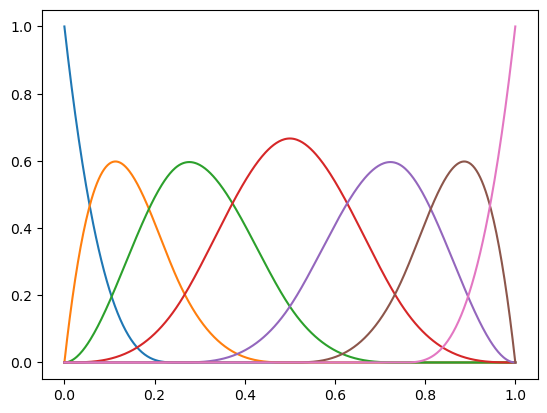

In [158]:
bsp_basis = BSplineBasis(n_basis=config["model_params"]["n_base"])
bsp_basis.plot();

In [152]:
tseq = np.linspace(0,1,101)
fd_test = FDataGrid(data_matrix=noise_test, grid_points=tseq)
fd_test_basis = fd_test.to_basis(bsp_basis)

Let's see B-spline's test error.

In [153]:
print("Test Loss:", np.mean((original_test - fd_test_basis(tseq).squeeze())**2))

Test Loss: 0.35225083130130486


Let's visualize the B-spline results of the first three test data.

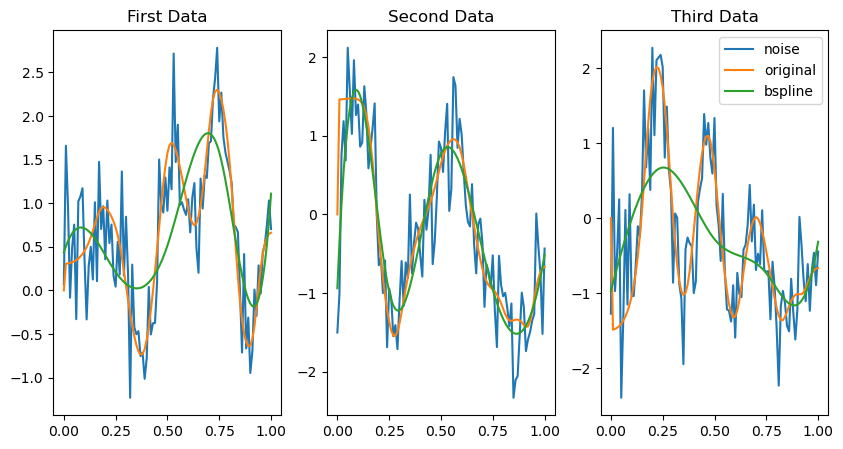

In [154]:
fig, ax = plt.subplots(1,3, figsize=(10,5))
ax[0].plot(tseq, noise_test[0], label="noise")
ax[0].plot(tseq, original_test[0], label="original")
ax[0].plot(tseq, fd_test_basis(tseq)[0], label="bspline")
ax[0].set_title("First Data")
ax[1].plot(tseq, noise_test[1], label="noise")
ax[1].plot(tseq, original_test[1], label="original")
ax[1].plot(tseq, fd_test_basis(tseq)[1], label="bspline")
ax[1].set_title("Second Data")
ax[2].plot(tseq, noise_test[2], label="noise")
ax[2].plot(tseq, original_test[2], label="original")
ax[2].plot(tseq, fd_test_basis(tseq)[2], label="bspline")
ax[2].set_title("Third Data")
plt.legend()
plt.show();

## FPCA

In [155]:
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.grid import FDataGrid

In [156]:
tseq = np.linspace(0,1,101)
fd_train = FDataGrid(data_matrix=noise_train, grid_points=tseq)

fpca = FPCA(n_components=config["model_params"]["n_base"])
# fpca_scores = fpca.fit_transform(fd)
fpca.fit(fd_train);

FPCA basis functions look as follows

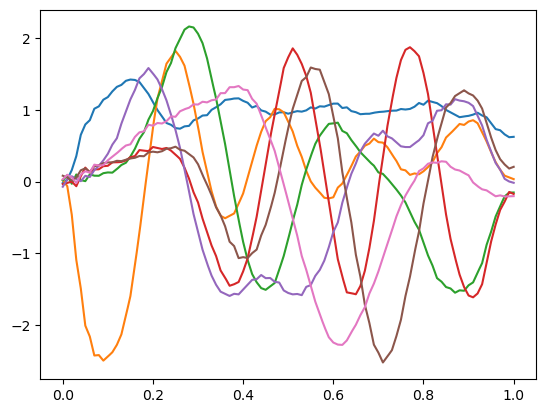

In [157]:
fpca.components_.plot();

In [159]:
fd_test = FDataGrid(data_matrix=noise_test, grid_points=tseq)
fpca_scores = fpca.transform(fd_test)
pred_fpca = np.matmul(fpca_scores, fpca.components_(tseq).squeeze())

Let's see FPCA's test error.

In [160]:
print("Test Loss:", np.mean((pred_fpca - original_test)**2))

Test Loss: 0.21258736949677587


Let's visualize the FPCA results of the first three test data.

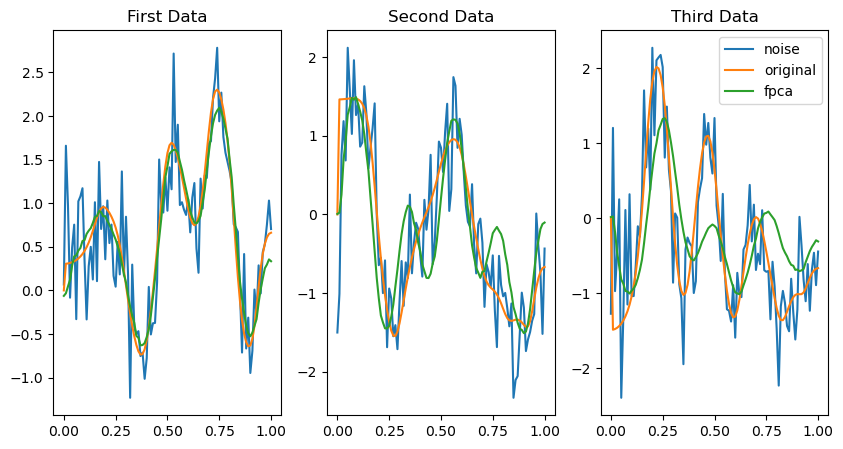

In [161]:
fig, ax = plt.subplots(1,3, figsize=(10,5))
ax[0].plot(tseq, noise_test[0], label="noise")
ax[0].plot(tseq, original_test[0], label="original")
ax[0].plot(tseq, pred_fpca[0], label="fpca")
ax[0].set_title("First Data")
ax[1].plot(tseq, noise_test[1], label="noise")
ax[1].plot(tseq, original_test[1], label="original")
ax[1].plot(tseq, pred_fpca[1], label="fpca")
ax[1].set_title("Second Data")
ax[2].plot(tseq, noise_test[2], label="noise")
ax[2].plot(tseq, original_test[2], label="original")
ax[2].plot(tseq, pred_fpca[2], label="fpca")
ax[2].set_title("Third Data")
plt.legend()
plt.show();

# Conclusion

FPCA seems to work the best in this case, but our model does outperform B-spline by a relatively big margin. However, our network is not yet perfectly optimized and leaves hope for better performance. Additionally, through this research, we could reap a new finding that by structuring our output according to Parceval's Theorem, we can construct orthonormal basis without any additional constraints are regularization.

# Reference

[1] Junwen Yao, Jonas Mueller, Jane-Ling Wang. Deep Learning for Functional Data Analysis with Adaptive Basis Layers. *ICML 2021*

# Code

Code can be found at https://github.com/bossacode/FDA